In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aux.ts_functions as ts
import seaborn as sns; sns.set()
import numpy as np
import warnings
import os
from scipy.stats import pearsonr
from IPython.display import Image
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import math
import glob
from functools import reduce
from scipy.special import comb
from numpy.linalg import LinAlgError
from matplotlib.offsetbox import AnchoredText

data_dir = "./../data/"

## Functions

### Loading

In [19]:
def get_ts(df, area, specie, toxin, resample_code, plot=True, show_df=False):
    if not isinstance(toxin, list):
        toxin = [toxin]
    ts = df[ (df["Production_Area"]==area) & (biotoxins_ts["Species"]==specie)]
    ts = ts.resample(resample_code).mean()
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ts.plot(ax=ax, marker='o', markersize=2)
    if show_df: 
        display(ts[toxin].head())
    return ts[toxin]

def get_ts_imputed(area, specie, toxin, suf, data_dir='/imputed_data', only_target=False):
    if suf == "areacorr":
        file_name = suf + '__' + area + '__' + toxin + '_' + specie
    elif suf == "speciecorr":
        file_name = suf + '__' + area + '_' + specie + '__' + toxin
    elif suf == "phytocorr":
        file_name = suf + '__' + area + '__' + toxin
    else:
        raise ValueError(f"Suffix {suf} is not valid.")
                    
    file = glob.glob(f'.{data_dir}/{file_name}*.csv')
    if len(file)>1:
        raise ValueError(f"Multiple files found when searching for '{file_name}'")
    elif len(file) == 0:
        raise FileNotFoundError(f"File '{file_name}' found")
    else:
        ts = pd.read_csv(file[0], index_col='Date', parse_dates=True)
        if only_target:
            if specie != None:
                return ts[[target + '_' + specie]]
            else:
                return ts[[target.replace('toxins','phyto')]]
        else:
            return ts



### Plot Correlations

In [31]:
def subplot_dim(total, n_cols):
    rows = total//n_cols
    if total%n_cols!=0:
        rows+=1
    return rows, n_cols

def plot_corrs_all(all_areas, min_corr, lags, area_groups, specie, target, suf="areacorr", type_corr="Pearson", 
                   k_range=range(2,21,2), use_imputed=True):
    selected_areas = set()
    k_dict = {}
    for i in range(len(all_areas)):
        for j in range(i):
            area1, area2 = all_areas[i], all_areas[j]
            key = "_".join(sorted([area1, area2]))
            check_groups = sum([ (area1 in g and area2 in g) for g in area_groups ])
            if check_groups:
                continue

            try:
                if use_imputed:
                    ts1 = get_ts_imputed(area1, specie, target, suf, only_target=True)
                    ts2 = get_ts_imputed(area2, specie, target, suf, only_target=True)
                else:
                    ts1 = get_ts(biotoxins_ts, area1, specie, target, "W", plot=False).interpolate(method="linear")
                    ts2 = get_ts(biotoxins_ts, area2, specie, target, "W", plot=False).interpolate(method="linear")
            except FileNotFoundError:
                continue

            df = pd.merge(ts1, ts2, left_index=True, right_index=True)
            col1, col2 = df.columns
            
            k_dict[key] = k_range
            if type_corr.lower() in ['dpcca', 'dcca'] and not isinstance(k_range, int):
                k_dict[key] = get_k_for_dpcca(df.copy(), k_range, lags, type_corr)

            for lag in lags:
                temp = df.copy()
                temp[col1] = temp[col1].shift(lag)
                if type_corr.lower() == 'pearson':
                    corr = temp[col1].corr(temp[col2], method='pearson')
                elif type_corr.lower() == 'dpcca':
                    corr = compute_dpcca_others(temp.dropna().values, k_dict[key])[3][0][1]
                elif type_corr.lower() == 'dcca':
                    corr = compute_dpcca_others(temp.dropna().values, k_dict[key])[2][0][1]
                else:
                    raise ValueError("Invalid type_corr")
                if abs(corr) > min_corr:
                    selected_areas.add(area1)
                    selected_areas.add(area2)
                    break
    
    selected_areas = list(selected_areas) 
    if len(selected_areas) == 0:
        print(f"No selected areas with threshold: {min_corr}")
        return -1
    print(selected_areas)

    #########################################

    areas = selected_areas

    fig, ax = plt.subplots(len(areas), len(areas), figsize=(10,12), constrained_layout=True, sharey=True)

    for i in range(len(areas)):
        for j in range(i+1):
            if type_corr in ["dpcca", "dcca"] and i==j:
                continue
            highlight = False
            area1, area2 = areas[i], areas[j]
            key = "_".join(sorted([area1, area2]))

            try:
                if use_imputed:
                    ts1 = get_ts_imputed(area1, specie, target, suf, only_target=True)
                    ts2 = get_ts_imputed(area2, specie, target, suf, only_target=True)
                else:
                    ts1 = get_ts(biotoxins_ts, area1, specie, target, "W", plot=False).interpolate(method="linear")
                    ts2 = get_ts(biotoxins_ts, area2, specie, target, "W", plot=False).interpolate(method="linear")
            except FileNotFoundError:
                continue
                
            df = pd.merge(ts1, ts2, left_index=True, right_index=True)
            col1, col2 = df.columns
            
            if type_corr.lower() in ['dpcca', 'dcca'] and key not in k_dict:
                k_dict[key] = k_range
                if not isinstance(k_range, int):
                    k_dict[key] = get_k_for_dpcca(df.copy(), k_range, lags, type_corr)

            df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan})
            for lag in lags:
                temp = df.copy()
                temp[col1] = temp[col1].shift(lag)
                if type_corr.lower() == 'pearson':
                    corr = temp[col1].corr(temp[col2], method='pearson')
                elif type_corr.lower() == 'dpcca':
                    corr = compute_dpcca_others(temp.dropna().values, k_dict[key])[3][0][1]
                elif type_corr.lower() == 'dcca':
                    corr = compute_dpcca_others(temp.dropna().values, k_dict[key])[2][0][1]
                else:
                    raise ValueError("Invalid type_corr")
                    
                if abs(corr) > min_corr and i!=j: 
                    highlight = True
                df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr

            sns.lineplot(data=df_corrs, x="lags", y="corrs", ax=ax[j,i])
            if type_corr.lower() in ['dpcca', 'dcca']:
                anchored_text = AnchoredText(f"k={k_dict[key]}", loc='lower left', prop=dict(size=8))
                ax[j,i].add_artist(anchored_text)
            if highlight:
                ax[j,i].spines['bottom'].set_color('green')
                ax[j,i].spines['top'].set_color('green')
                ax[j,i].spines['left'].set_color('green')
                ax[j,i].spines['right'].set_color('green')
                ax[j,i].axvline(0, linestyle="--", color="r", linewidth=0.5)
                ax[j,i].axhline(0, linestyle="-", color="black", linewidth=0.5)


            #ax[j,i].set(xticklabels=lags)

    for i in range(len(areas)):
        ax[0][i].set_title(areas[i])
        for j in range(len(areas)):
            ax[j][0].set_ylabel(areas[j], size='medium')

            ax[j,i].tick_params(axis='both', labelsize="x-small")
            #ax[j,i].tick_params(axis='x', labelsize="x-small")
            ax[j,i].set(xlabel=None, ylabel=None)

            if (j>i) or (j==i and type_corr.lower() in ['dpcca', 'dcca']):
                ax[j,i].set(xticklabels=[])
                ax[j,i].tick_params(bottom=False)  # remove the ticks


    plt.show()
    
    
def plot_corrs_single(all_areas, min_corr, lags, area_groups, specie, target, suf="areacorr", type_corr="Pearson",
                      subplots_per_line=4, use_imputed=True, k_range=range(2,21,2), remove_default=False,
                     min_points_default=20, annotate=None):
    selected_areas = set()
    all_corrs = []
    k_dict = {}
    for i in range(len(all_areas)):
        for j in range(i):
            area1, area2 = all_areas[i], all_areas[j]
            key = "_".join(sorted([area1, area2]))
            
            check_groups = sum([ (area1 in g and area2 in g) for g in area_groups ])
            if check_groups:
                continue
            
            try:
                if use_imputed:
                    ts1 = get_ts_imputed(area1, specie, target, suf, only_target=True)
                    ts2 = get_ts_imputed(area2, specie, target, suf, only_target=True)
                else:
                    ts1 = get_ts(biotoxins_ts, area1, specie, target, "W", plot=False).interpolate(method="linear")
                    ts2 = get_ts(biotoxins_ts, area2, specie, target, "W", plot=False).interpolate(method="linear")
            except FileNotFoundError:
                continue
            
            df = pd.merge(ts1, ts2, left_index=True, right_index=True)
            col1, col2 = df.columns
            df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'pvalue': np.nan, 'annotate': False,
                                     'areas': key})
            
          
                
            plot = False
            for lag in lags:
                temp = df.copy()
                shift_ts = temp[col2].shift(lag)
                if type_corr.lower() == 'pearson':
                    if remove_default:
                        default = temp[col1].mode().values[0]
                        temp = temp[~((abs(temp[col1]-default)<default*0.05) & (abs(shift_ts-default)<default*0.05))]                        
                    #corr = temp[col1].corr(shift_ts, method='pearson', min_periods=min_points_default)
                    to_corr = pd.DataFrame({ 'a': temp[col1], 'b': shift_ts }).dropna()
                    try:
                        corr, pvalue = pearsonr(to_corr['a'].values, to_corr['b'].values)
                    except ValueError:
                        continue
                else:
                    raise ValueError("Invalid type_corr")
                df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
                df_corrs.loc[df_corrs['lags'] == lag, 'pvalue'] = pvalue

                if abs(corr) > min_corr:
                    plot = True

            if plot:
                if annotate != None:
                    index_top = df_corrs["corrs"].nlargest(n=annotate).index
                    df_corrs.at[index_top, 'annotate'] = True
                all_corrs.append(df_corrs)

                
        
    if len(all_corrs)==0:
        raise ValueError("Threshold too high, no correlations found")
    all_corrs = pd.concat(all_corrs)
    selected_areas = all_corrs["areas"].unique()
    
    rows, columns = subplot_dim(len(selected_areas), subplots_per_line)
    fig, axes = plt.subplots(rows, columns, 
                             figsize=(8, 3*rows), constrained_layout=True, 
                             sharey=True, squeeze=False)

    axes = axes.ravel()
    for i, areas in enumerate(selected_areas):
        temp_df = all_corrs[all_corrs["areas"] == areas]
        sns.lineplot(data=temp_df, x="lags", y="corrs", marker='o', markersize=4, ax=axes[i])
        if type_corr.lower() in ['dpcca', 'dcca']:
            anchored_text = AnchoredText(f"k={k_dict[areas]}", loc='lower left', prop=dict(size=8))
            axes[i].add_artist(anchored_text)
        axes[i].set_title(f'{areas}', size="small")
        axes[i].tick_params(axis='both', labelsize="x-small")
        axes[i].set(xlabel=None, ylabel=None)
        #axes[i].set_ylim(-0.2,1)
        axes[i].axvline(0, linestyle="--", color="r", linewidth=0.5)
        axes[i].axhline(0, linestyle="-", color="black", linewidth=0.5)
        
        if annotate!=None:
            shifts = [-0.3]*(annotate//2) + [0.3]*(annotate - (annotate//2))
            aligns = ["right"]*(annotate//2) + ["left"]*(annotate - (annotate//2))
            for line in range(0,temp_df.shape[0]):
                if temp_df["annotate"][line]:
                    axes[i].text(temp_df["lags"][line]+shifts.pop(0), temp_df["corrs"][line], 
                            round(temp_df["pvalue"][line],5), horizontalalignment=aligns.pop(0), size='xx-small', 
                            color='black')


    plt.show()
    
def plot_corrs_together(all_areas, min_corr, lags, area_groups, specie, target, suf="areacorr", type_corr="Pearson",
                      subplots_per_line=4, use_imputed=True, remove_default=False, min_points_default=20):
    selected_areas = set()
    all_corrs = []
    k_dict = {}
    for i in range(len(all_areas)):
        for j in range(i):
            area1, area2 = all_areas[i], all_areas[j]
            key = "_".join(sorted([area1, area2]))
            
            check_groups = sum([ (area1 in g and area2 in g) for g in area_groups ])
            if check_groups:
                continue
            
            try:
                if use_imputed:
                    ts1 = get_ts_imputed(area1, specie, target, suf, only_target=True)
                    ts2 = get_ts_imputed(area2, specie, target, suf, only_target=True)
                else:
                    ts1 = get_ts(biotoxins_ts, area1, specie, target, "W", plot=False).interpolate(method="linear")
                    ts2 = get_ts(biotoxins_ts, area2, specie, target, "W", plot=False).interpolate(method="linear")
            except FileNotFoundError:
                continue
            
            df = pd.merge(ts1, ts2, left_index=True, right_index=True)
            col1, col2 = df.columns
            df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'areas': key})
            
          
                
            plot = False
            for lag in lags:
                temp = df.copy()
                shift_ts = temp[col2].shift(lag)
                if type_corr.lower() == 'pearson':
                    if remove_default:
                        default = temp[col1].mode().values[0]
                        temp = temp[~((abs(temp[col1]-default)<default*0.05) & (abs(shift_ts-default)<default*0.05))]                        
                    corr = temp[col1].corr(shift_ts, method='pearson', min_periods=min_points_default)
                else:
                    raise ValueError("Invalid type_corr")
                df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
                if abs(corr) > min_corr:
                    plot = True
                    
            if plot:
                all_corrs.append(df_corrs)
        
    if len(all_corrs)==0:
        raise ValueError("Threshold too high, no correlations found")
    all_corrs = pd.concat(all_corrs).reset_index(drop=True)
    selected_areas = all_corrs["areas"].unique()
    fig, axes = plt.subplots(1, 1,  figsize=(12, 4), constrained_layout=True, sharey=True)
    
    sns.lineplot(data=all_corrs, x="lags", y="corrs", hue="areas", marker='o', markersize=4, ax=axes)

    axes.tick_params(axis='both', labelsize="x-small")
    axes.set(xlabel=None, ylabel=None)
    axes.axvline(0, linestyle="--", color="r", linewidth=0.5)
    axes.axhline(0, linestyle="-", color="black", linewidth=0.5)

    plt.show()
    
    

def plot_dpcca_single(all_areas, min_corr, lags, area_groups, specie, target, suf="areacorr", 
                      type_corr="dpcca", subplots_per_line=3, use_imputed=True, k_range=[12]):
    selected_areas = set()
    all_corrs = []
    k_dict = {}
    for i in range(len(all_areas)):
        for j in range(i):
            area1, area2 = all_areas[i], all_areas[j]
            key = "_".join(sorted([area1, area2]))
            
            check_groups = sum([ (area1 in g and area2 in g) for g in area_groups ])
            if check_groups:
                continue
            
            try:
                if use_imputed:
                    ts1 = get_ts_imputed(area1, specie, target, suf, only_target=True)
                    ts2 = get_ts_imputed(area2, specie, target, suf, only_target=True)
                else:
                    ts1 = get_ts(biotoxins_ts, area1, specie, target, "W", plot=False).interpolate(method="linear")
                    ts2 = get_ts(biotoxins_ts, area2, specie, target, "W", plot=False).interpolate(method="linear")
            except FileNotFoundError:
                continue
            
            df = pd.merge(ts1, ts2, left_index=True, right_index=True)
            col1, col2 = df.columns
            
            
            df_corrs = pd.DataFrame(columns=["lags", "corrs","areas",'n'])
            for n in k_range:
                df_corrs = df_corrs.append(pd.DataFrame({'lags':lags, 'corrs':np.nan, 'areas':key, 'n':str(n)}),
                                          ignore_index=True)
            #display(df_corrs)
            
            plot = False
            for n in k_range:
                for lag in lags:
                    temp = df.copy()
                    temp[col1] = df[col1].shift(lag)

                    if type_corr.lower() == 'dpcca':
                        z = 3
                    elif type_corr.lower() == "dcca":
                        z = 2
                    else:
                        raise ValueError("Invalid type_corr")
                    corr = compute_dpcca_others(temp.dropna().values, n)[z][0][1]
                    
                    df_corrs.loc[(df_corrs['lags'] == lag) & (df_corrs['n']==str(n)), 'corrs'] = corr
                    if abs(corr) > min_corr:
                        plot = True
            #display(df_corrs)    
            if plot:
                all_corrs.append(df_corrs)
        
    if len(all_corrs)==0:
        raise ValueError("Threshold too high, no correlations found")
    all_corrs = pd.concat(all_corrs)
    selected_areas = all_corrs["areas"].unique()
    fig, axes = plt.subplots(len(selected_areas)//subplots_per_line + 1, subplots_per_line,  
                             figsize=(8,3*len(selected_areas)//subplots_per_line+1), constrained_layout=True, 
                             sharey=True)
    axes = axes.ravel()
    for i, areas in enumerate(selected_areas):
        temp_df = all_corrs[all_corrs["areas"] == areas]
        sns.lineplot(data=temp_df, x="lags", y="corrs", hue="n", marker='o', markersize=4, ax=axes[i])
        #if type_corr.lower() in ['dpcca', 'dcca']:
            #anchored_text = AnchoredText(f"k={k_dict[areas]}", loc='lower left', prop=dict(size=8))
            #axes[i].add_artist(anchored_text)
        axes[i].set_title(f'{areas}', size="small")
        axes[i].tick_params(axis='both', labelsize="x-small")
        axes[i].set(xlabel=None, ylabel=None)
        #axes[i].set_ylim(-0.2,1)
        axes[i].axvline(0, linestyle="--", color="r", linewidth=0.5)
        axes[i].axhline(0, linestyle="-", color="black", linewidth=0.5)
        axes[i].legend(prop={'size': 6})

    plt.show()

### Imputation

In [21]:
def seasonal_mean(ts, n, lr=1):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

# linear, quadratic, cubic, knn, seasonal_year, seasonal_month 
def plot_imputations(ts, target, imputations, begin, end, n_neighbours=10):
    n = len(imputations)
    fig, ax = plt.subplots(n+1,1, figsize=(12,14), constrained_layout=True)
    
    imp = ts[target].interpolate(method="linear")
    imp.plot(ax=ax[0], style='-r')
    ts[target].plot(ax=ax[0], style='-b')
    ax[0].set_title("Example imputation")
    
    i = 1
    if "linear" in imputations:
        imp = ts[target].interpolate(method="linear")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Linear interpolation")
        i+=1
        
    if "quadratic" in imputations:
        imp = ts[target].interpolate(method="quadratic")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Quadratic interpolation")
        i+=1
        
    if "cubic" in imputations:
        imp = ts[target].interpolate(method="cubic")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Cubic interpolation")
        i+=1
        
    if "knn" in imputations:
        imp = pd.Series(data=knn_mean(ts[target], n_neighbours), index=ts[target].index)
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("KNN mean")
        i+=1
        
    if "seasonal_year" in imputations:
        imp = ts.copy()
        imp[target] = seasonal_mean(ts[target], n=52)
        imp = imp[target]
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Seasonal (year) mean")
        i+=1
        
    if "seasonal_month" in imputations:
        imp = ts.copy()
        imp[target] = seasonal_mean(ts[target], n=4)
        imp = imp[target]
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Seasonal (month) mean")
        i+=1
    
    plt.show()

### DPCCA

In [22]:
# Return sliding windows
def sliding_window(xx,k):
    # Function to generate boxes given dataset(xx) and box size (k)
    import numpy as np

    # generate indexes! O(1) way of doing it :)
    idx = np.arange(k)[None, :]+np.arange(len(xx)-k+1)[:, None]
    return xx[idx],idx

def compute_dpcca_others(cdata,k):
    # Input: cdata(nsamples,nvars), k: time scale for dpcca
    # Output: dcca, dpcca, corr, partialCorr
    #
    # Date(last modification): 02/15/2018
    # Author: Jaime Ide (jaime.ide@yale.edu)
    
    # Code distributed "as is", in the hope that it will be useful, but WITHOUT ANY WARRANTY;
    # without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
    # See the GNU General Public License for more details.
    
    import numpy as np
    from numpy.matlib import repmat
    
    
    # Define
    nsamples,nvars = cdata.shape

    # Cummulative sum after removing mean
    #cdata = signal.detrend(cdata,axis=0) # different from only removing the mean...
    cdata = cdata-cdata.mean(axis=0)
    xx = np.cumsum(cdata,axis=0)
    
    F2_dfa_x = np.zeros(nvars)
    allxdif = []
    # Get alldif and F2_dfa
    for ivar in range(nvars): # do for all vars
        xx_swin , idx = sliding_window(xx[:,ivar],k)
        nwin = xx_swin.shape[0]
        b1, b0 = np.polyfit(np.arange(k),xx_swin.T,deg=1) # linear fit (UPDATE if needed)
        
        #x_hat = [[b1[i]*j+b0[i] for j in range(k)] for i in range(nwin)] # Slower version
        x_hatx = repmat(b1,k,1).T*repmat(range(k),nwin,1) + repmat(b0,k,1).T
    
        # Store differences to the linear fit
        xdif = xx_swin-x_hatx
        allxdif.append(xdif)
        # Eq.4
        F2_dfa_x[ivar] = (xdif**2).mean()
    # Get the DCCA matrix
    dcca = np.zeros([nvars,nvars])
    for i in range(nvars): # do for all vars
        for j in range(nvars): # do for all vars
            # Eq.5 and 6
            F2_dcca = (allxdif[i]*allxdif[j]).mean()
            # Eq.1: DCCA
            dcca[i,j] = F2_dcca / np.sqrt(F2_dfa_x[i] * F2_dfa_x[j])   
    
    # Get DPCCA
    C = np.linalg.inv(dcca)
    
    # (Clear but slow version)
    #dpcca = np.zeros([nvars,nvars])
    #for i in range(nvars):
    #    for j in range(nvars):
    #        dpcca[i,j] = -C[i,j]/np.sqrt(C[i,i]*C[j,j])
    
    # DPCCA (oneliner version)
    mydiag = np.sqrt(np.abs(np.diag(C)))
    dpcca = (-C/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)
    
    # Include correlation and partial corr just for comparison ;)
    # Compute Corr
    corr = np.corrcoef(cdata.T)
    # Get parCorr
    cov = np.cov(cdata.T)
    C0 = np.linalg.inv(cov)
    mydiag = np.sqrt(np.abs(np.diag(C0)))
    parCorr = (-C0/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)

    return corr,parCorr,dcca,dpcca

def get_k_for_dpcca(df, k_range, lags, type_corr):
    col1, col2 = df.columns
    corrs_per_k = {}
    for k in k_range:
        max_corr = 0
        for lag in lags:
            df[col1] = df[col1].shift(lag)
            try: 
                if type_corr.lower() == 'dpcca':
                    corr = compute_dpcca_others(df.dropna().values, k)[3][0][1]
                elif type_corr.lower() == 'dcca':
                    corr = compute_dpcca_others(df.dropna().values, k)[2][0][1]
                else:
                    raise ValueError("Invalid type_corr")
            except LinAlgError:
                print("LinAlgError for k = ", k)
                continue
                
            if abs(corr) > max_corr:
                max_corr = abs(corr)
        corrs_per_k[k] = max_corr
    return max(corrs_per_k, key=corrs_per_k.get)


# Loading

In [23]:
biotoxins_ts = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")
biotoxins_ts

,Sample,Species,Sample_Point,Production_Area,dsp_toxins,asp_toxins,psp_toxins
Date,,,,,,,
2015-01-05,1,Mexilhão,Jangada,LAL,20.0,1.8,71.0
2015-01-05,20,Berbigão,Canal do Espinheiro,RIAV3,36.0,1.8,71.0
2015-01-05,19,Berbigão,Costa Nova,RIAV2,26.0,1.8,71.0
2015-01-05,18,Berbigão,Moacha,RIAV1,36.0,1.8,71.0
2015-01-05,17,Amêijoa-branca,Torreira,L3,36.0,1.8,71.0
...,...,...,...,...,...,...,...
2020-12-29,2211,Mexilhão,Povoação,POR2,36.0,1.8,NaN
2020-12-29,2212,Mexilhão,Aljezur,L7a,36.0,NaN,NaN
2020-12-29,2213,Mexilhão,Garganta,OLH4,36.0,NaN,NaN


# Areas

In [24]:
suf = "areacorr"
area_groups = [['OLH1', "OLH2", 'OLH3', 'OLH4', 'OLH5'], ['RIAV1', 'RIAV2', 'RIAV3', 'RIAV4']]
lags = np.arange(-10, 11, 1)

## Pearson

### Mexilhão

In [25]:
specie = "Mexilhão"
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()
corr = 0.7

#### DSP

In [9]:
target = "dsp_toxins"

##### With restrictions

In [11]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson')

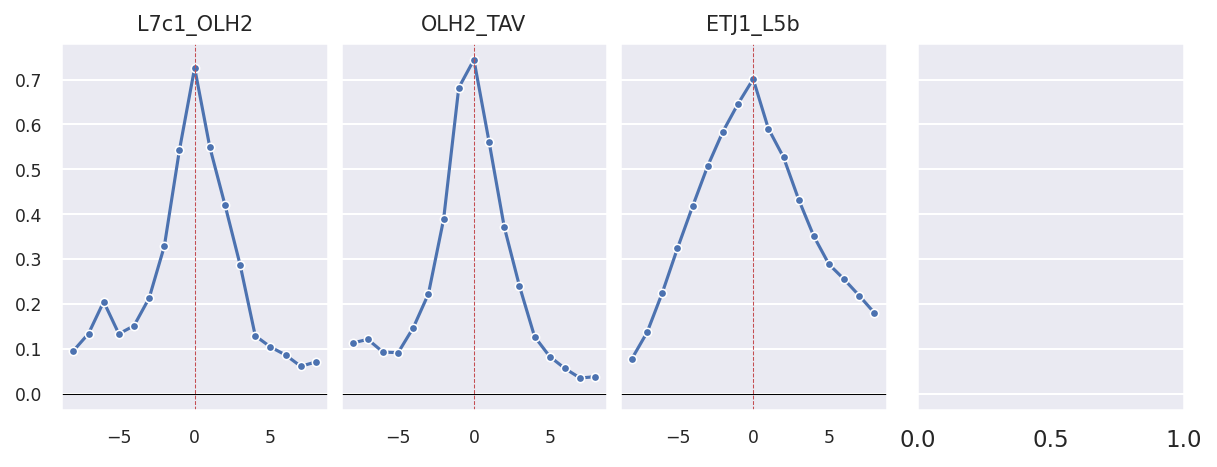

In [11]:
plot_corrs_single(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson')

##### Without restrictions

In [24]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='pearson')

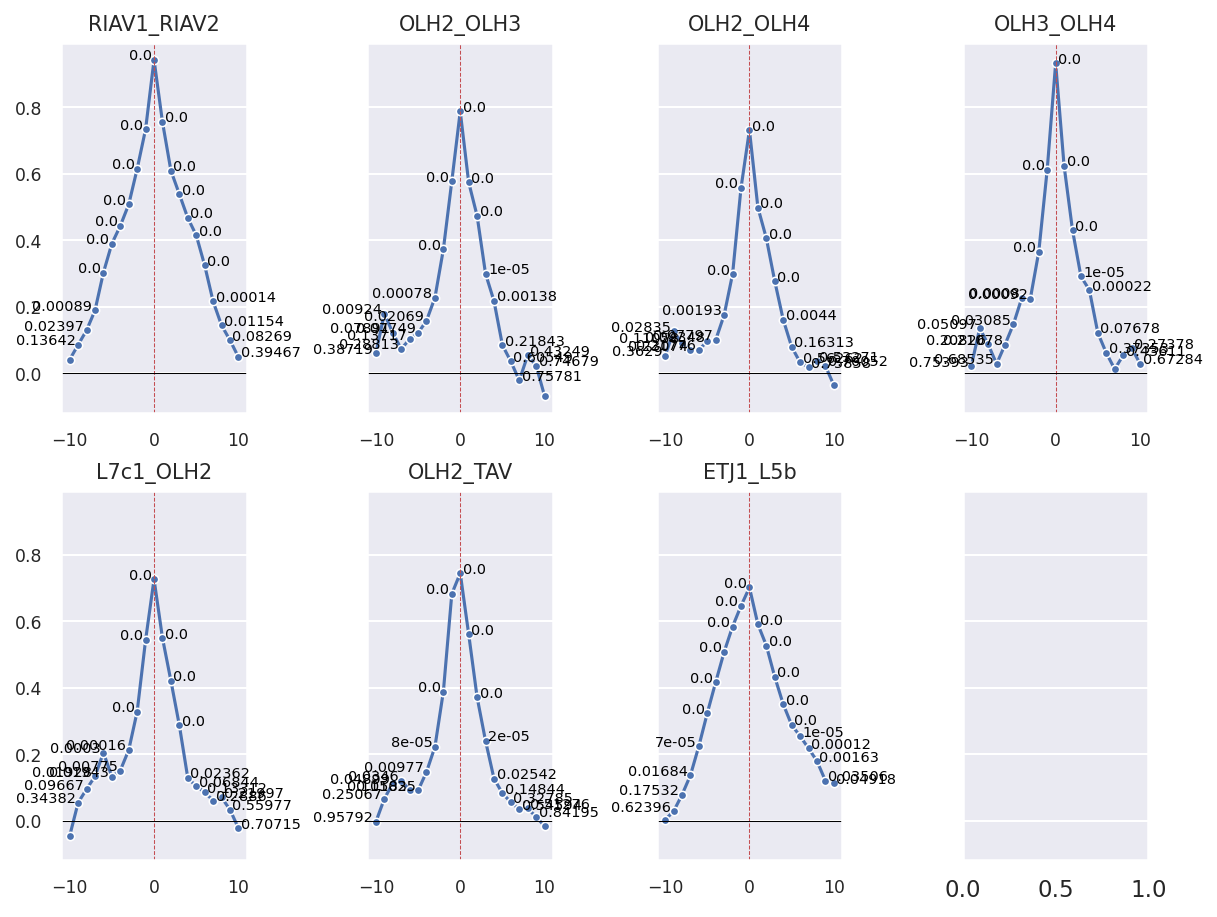

In [10]:
plot_corrs_single(all_areas, corr, lags, [], specie, target, type_corr='pearson', annotate=20)

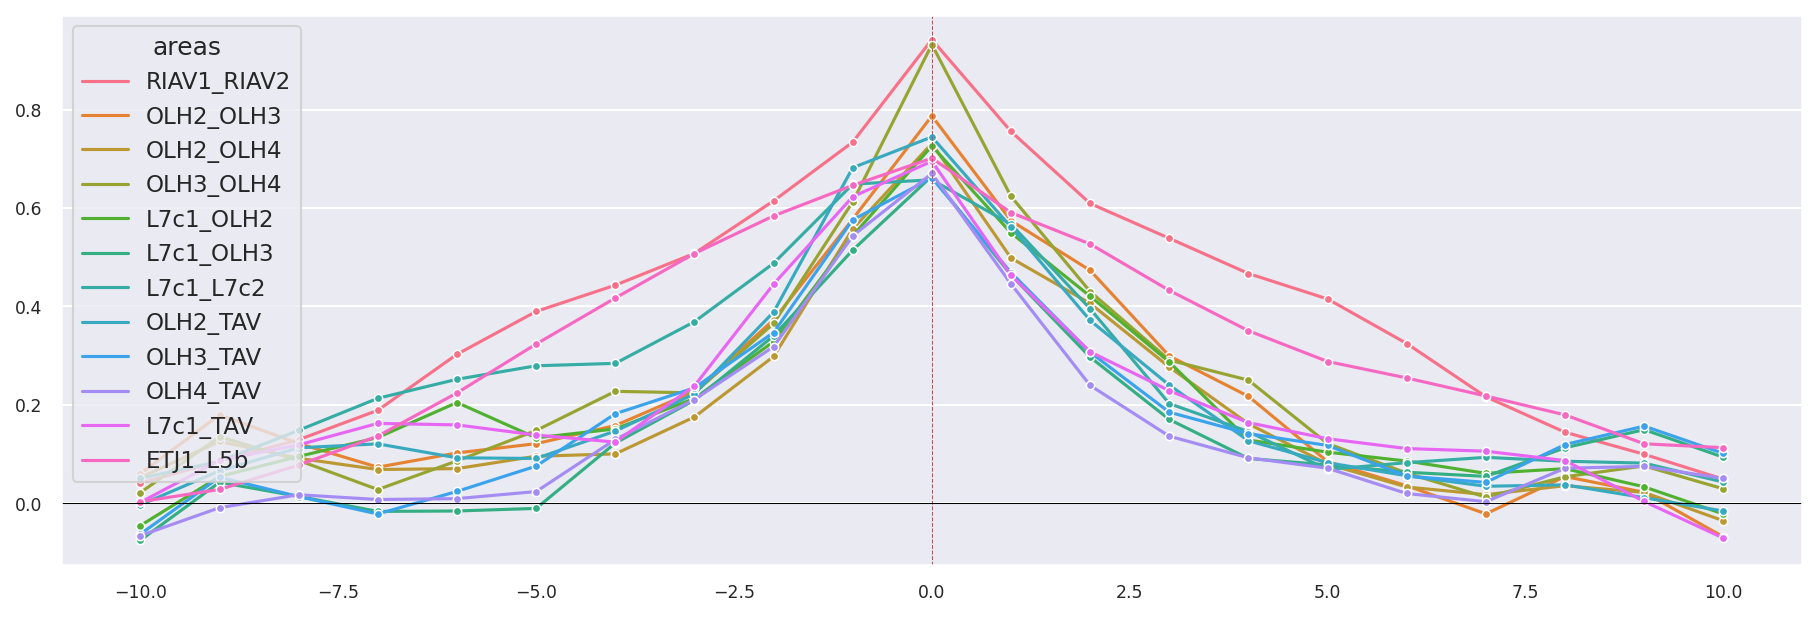

In [11]:
plot_corrs_together(all_areas, 0.65, lags, [], specie, target, type_corr='pearson')

##### example graphic

In [43]:
plot_corrs_single(["ETJ1", "L5b"], corr, lags, [], specie, target, type_corr='pearson',subplots_per_line=1,
                 annotate=3)

ValueError: Threshold too high, no correlations found

#### ASP

In [26]:
target = "asp_toxins"

##### With restrictions

In [51]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson')

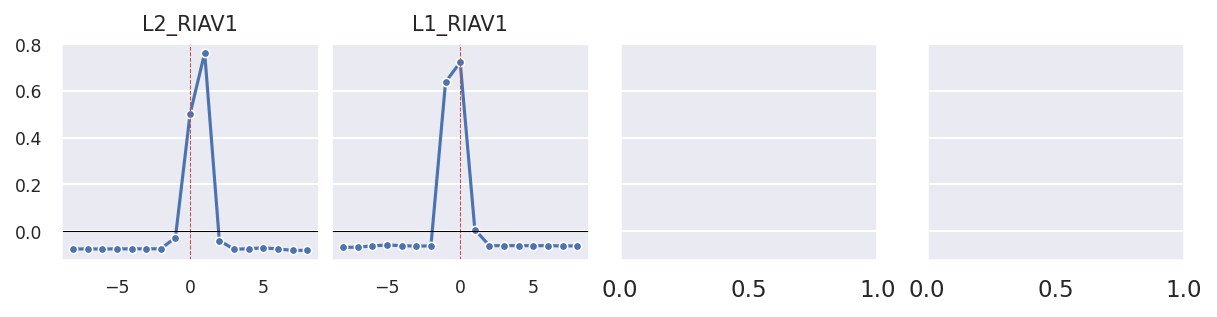

In [52]:
plot_corrs_single(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson', remove_default=True)

##### Without restrictions

In [27]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='pearson')

/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


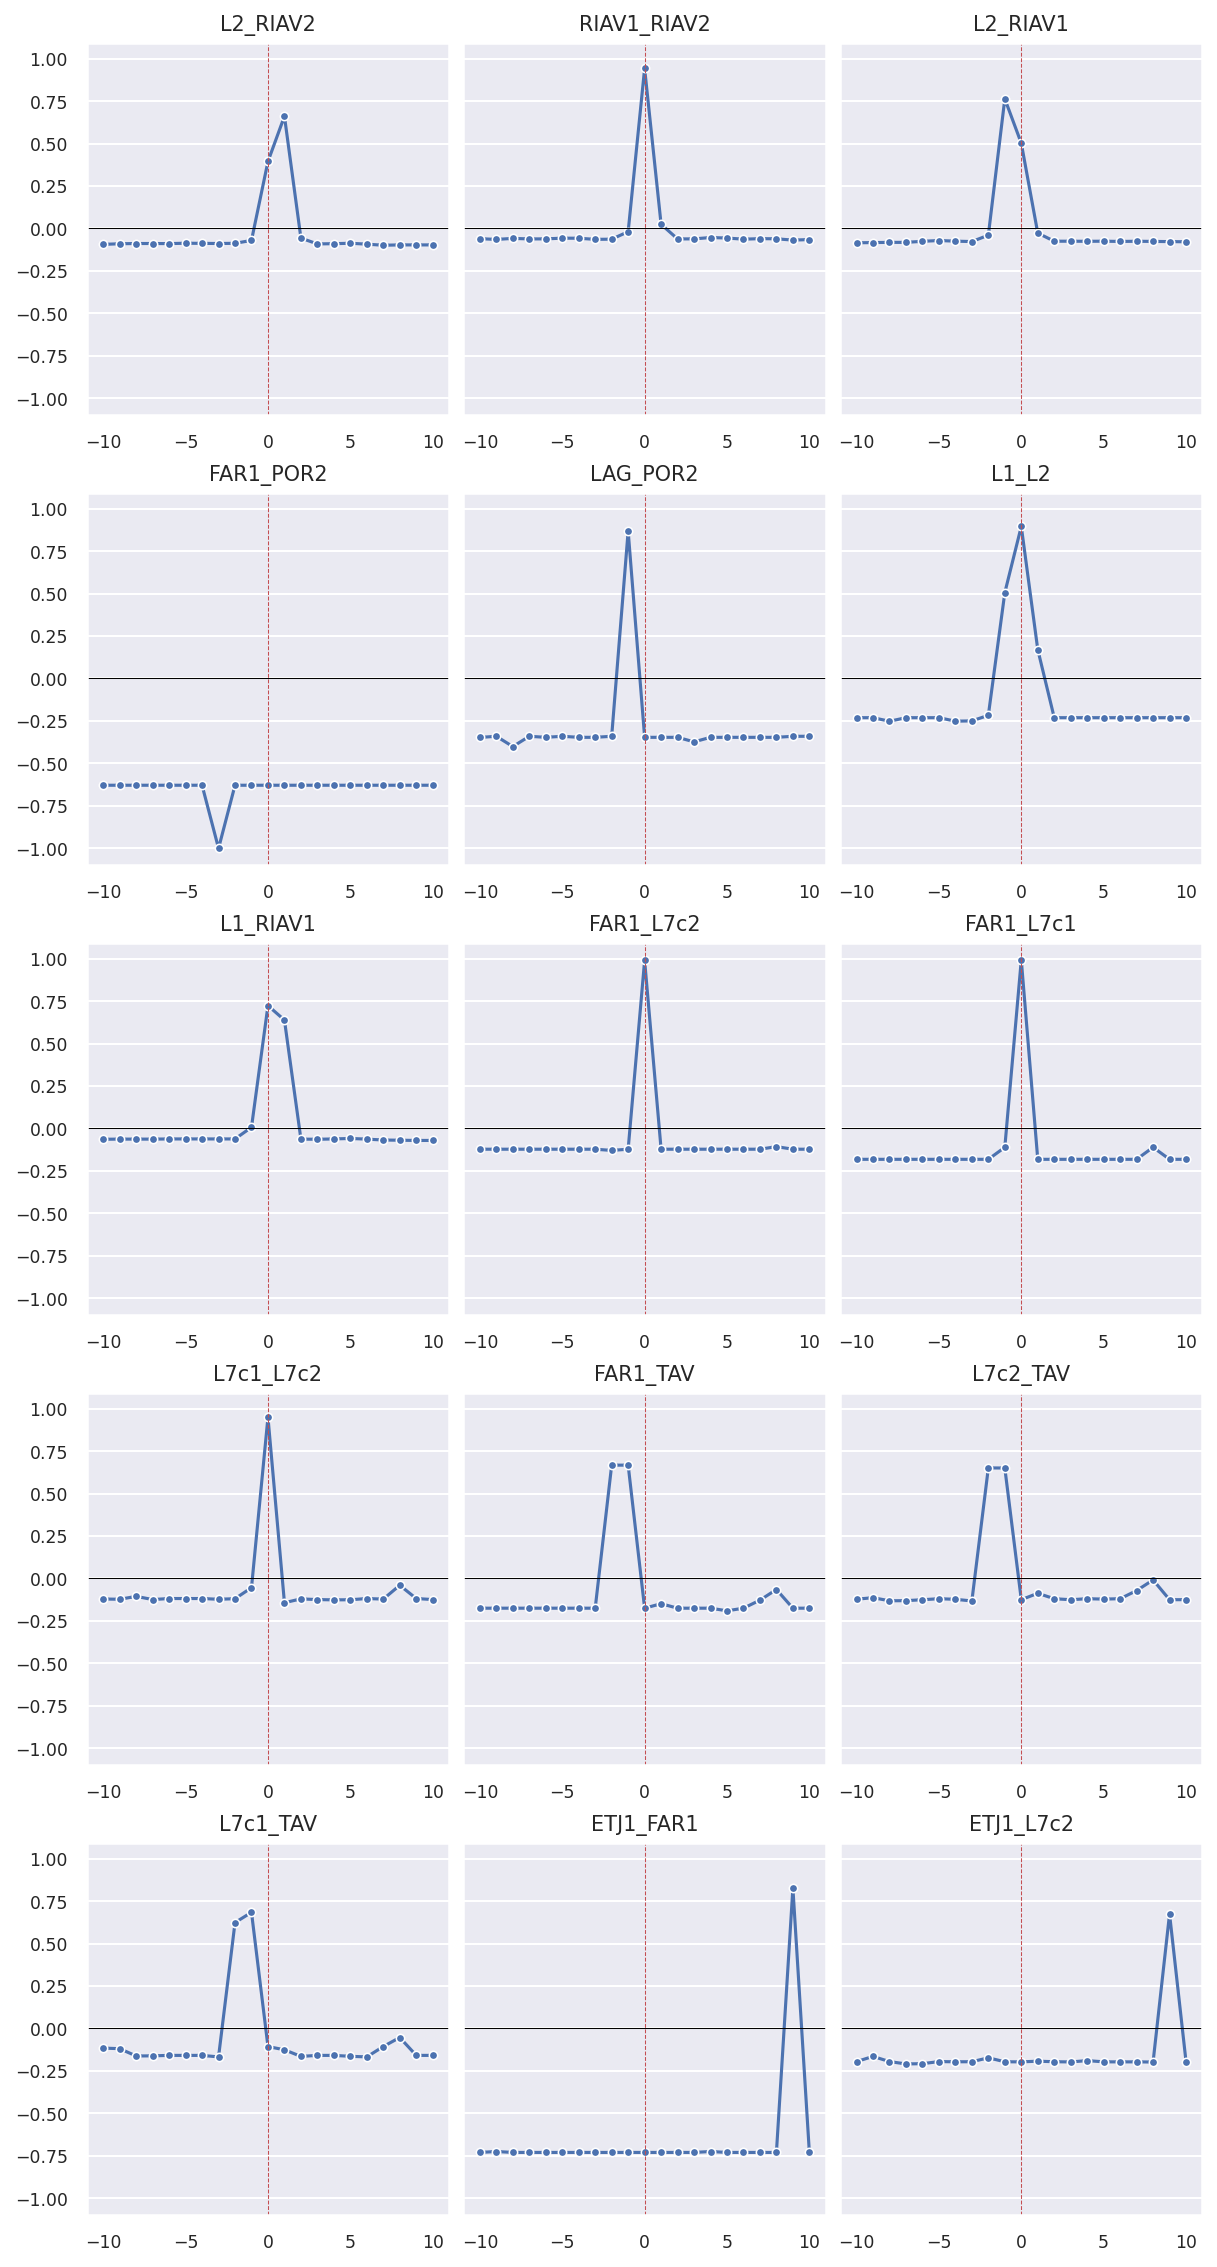

In [32]:
plot_corrs_single(all_areas, 0.65, lags, [], specie, target, type_corr='pearson', remove_default=True, 
                  subplots_per_line=3)

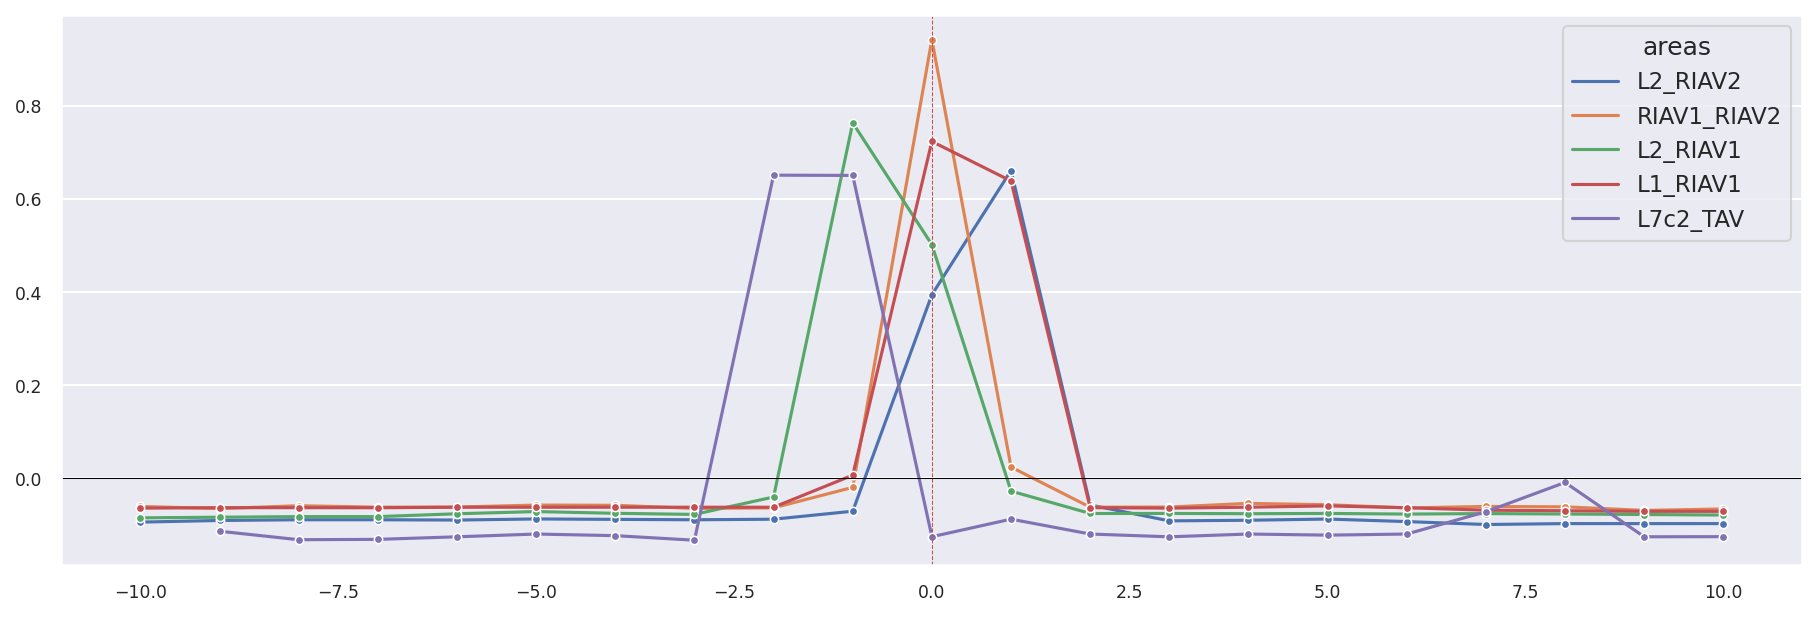

In [33]:
plot_corrs_together(all_areas, 0.65, lags, [], specie, target, type_corr='pearson', remove_default=True)

#### PSP

In [18]:
target = "psp_toxins"

##### With restrictions

In [56]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson')

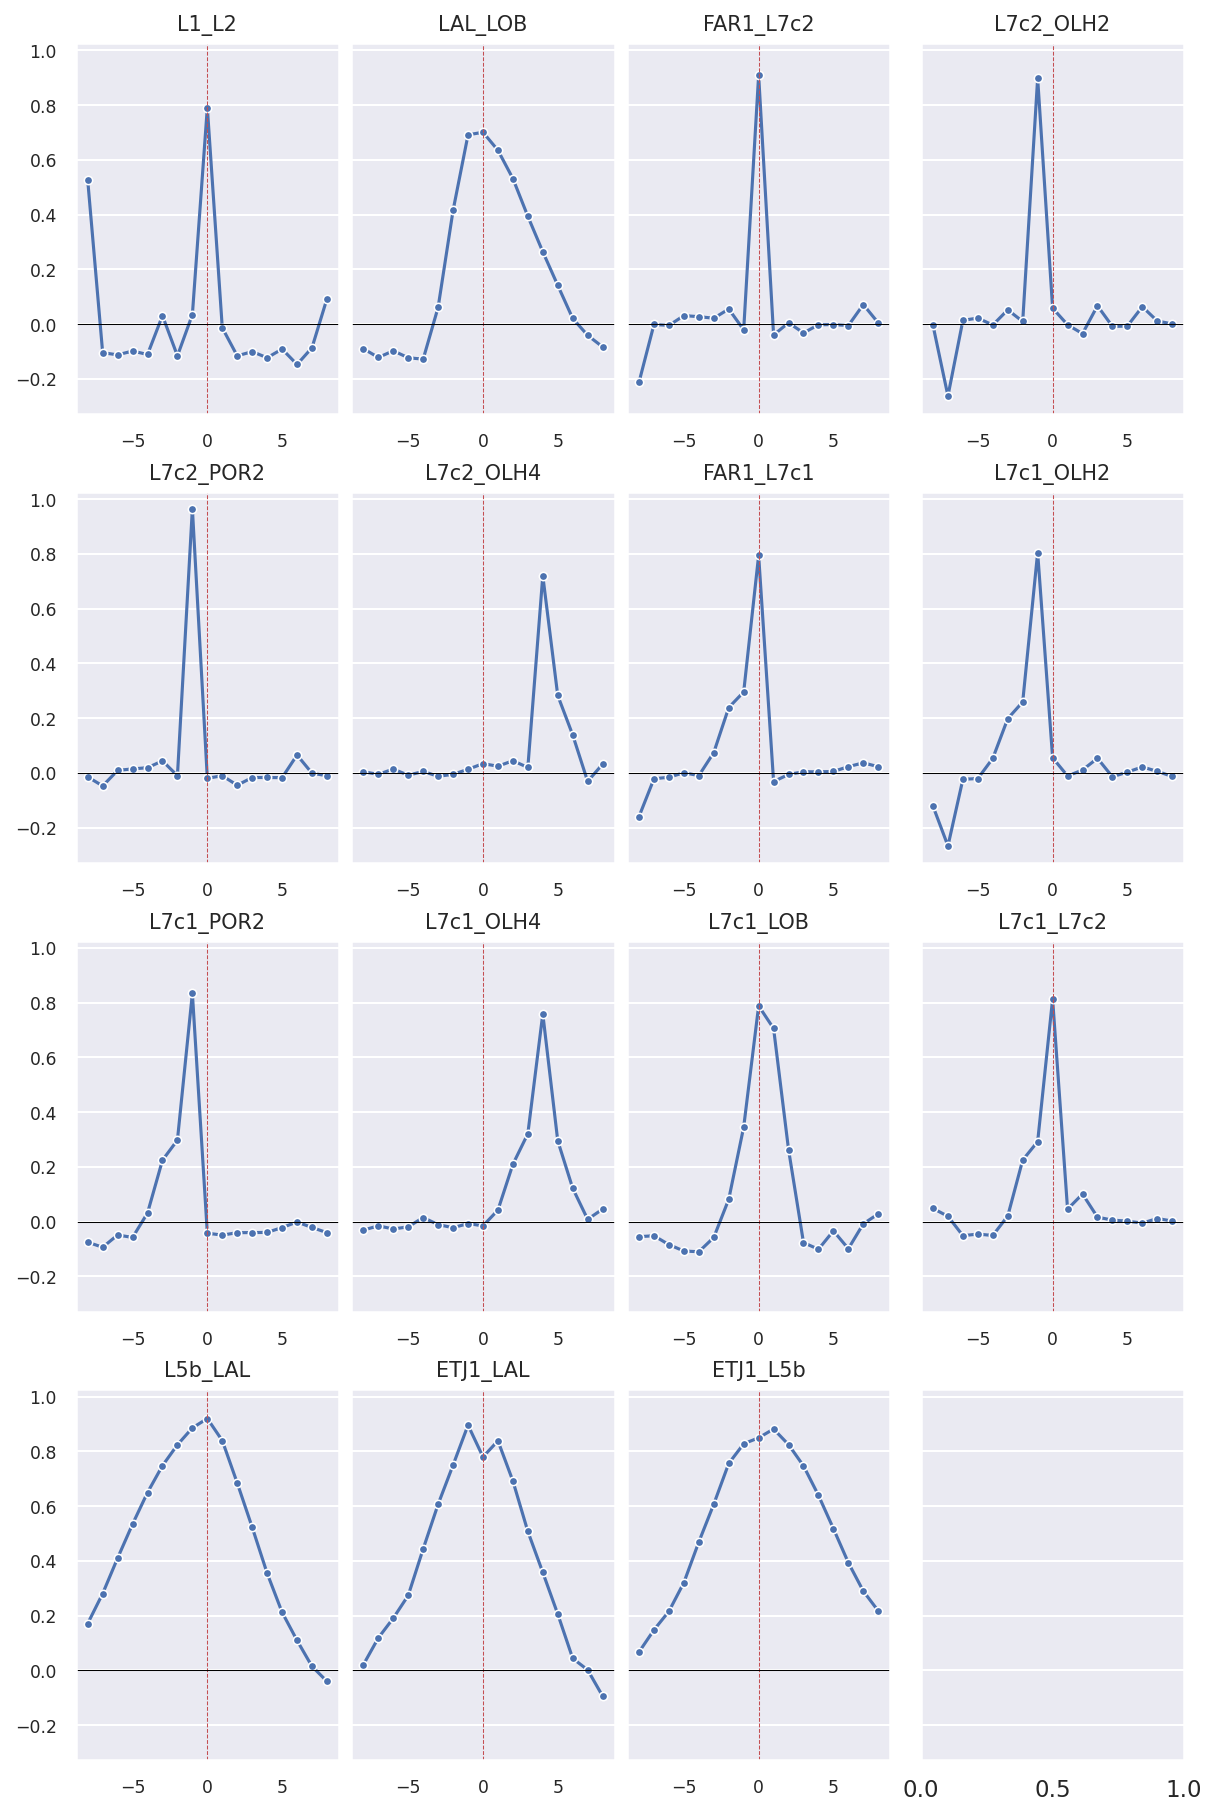

In [57]:
plot_corrs_single(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson', remove_default=True)

##### Without restrictions

In [20]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='pearson')

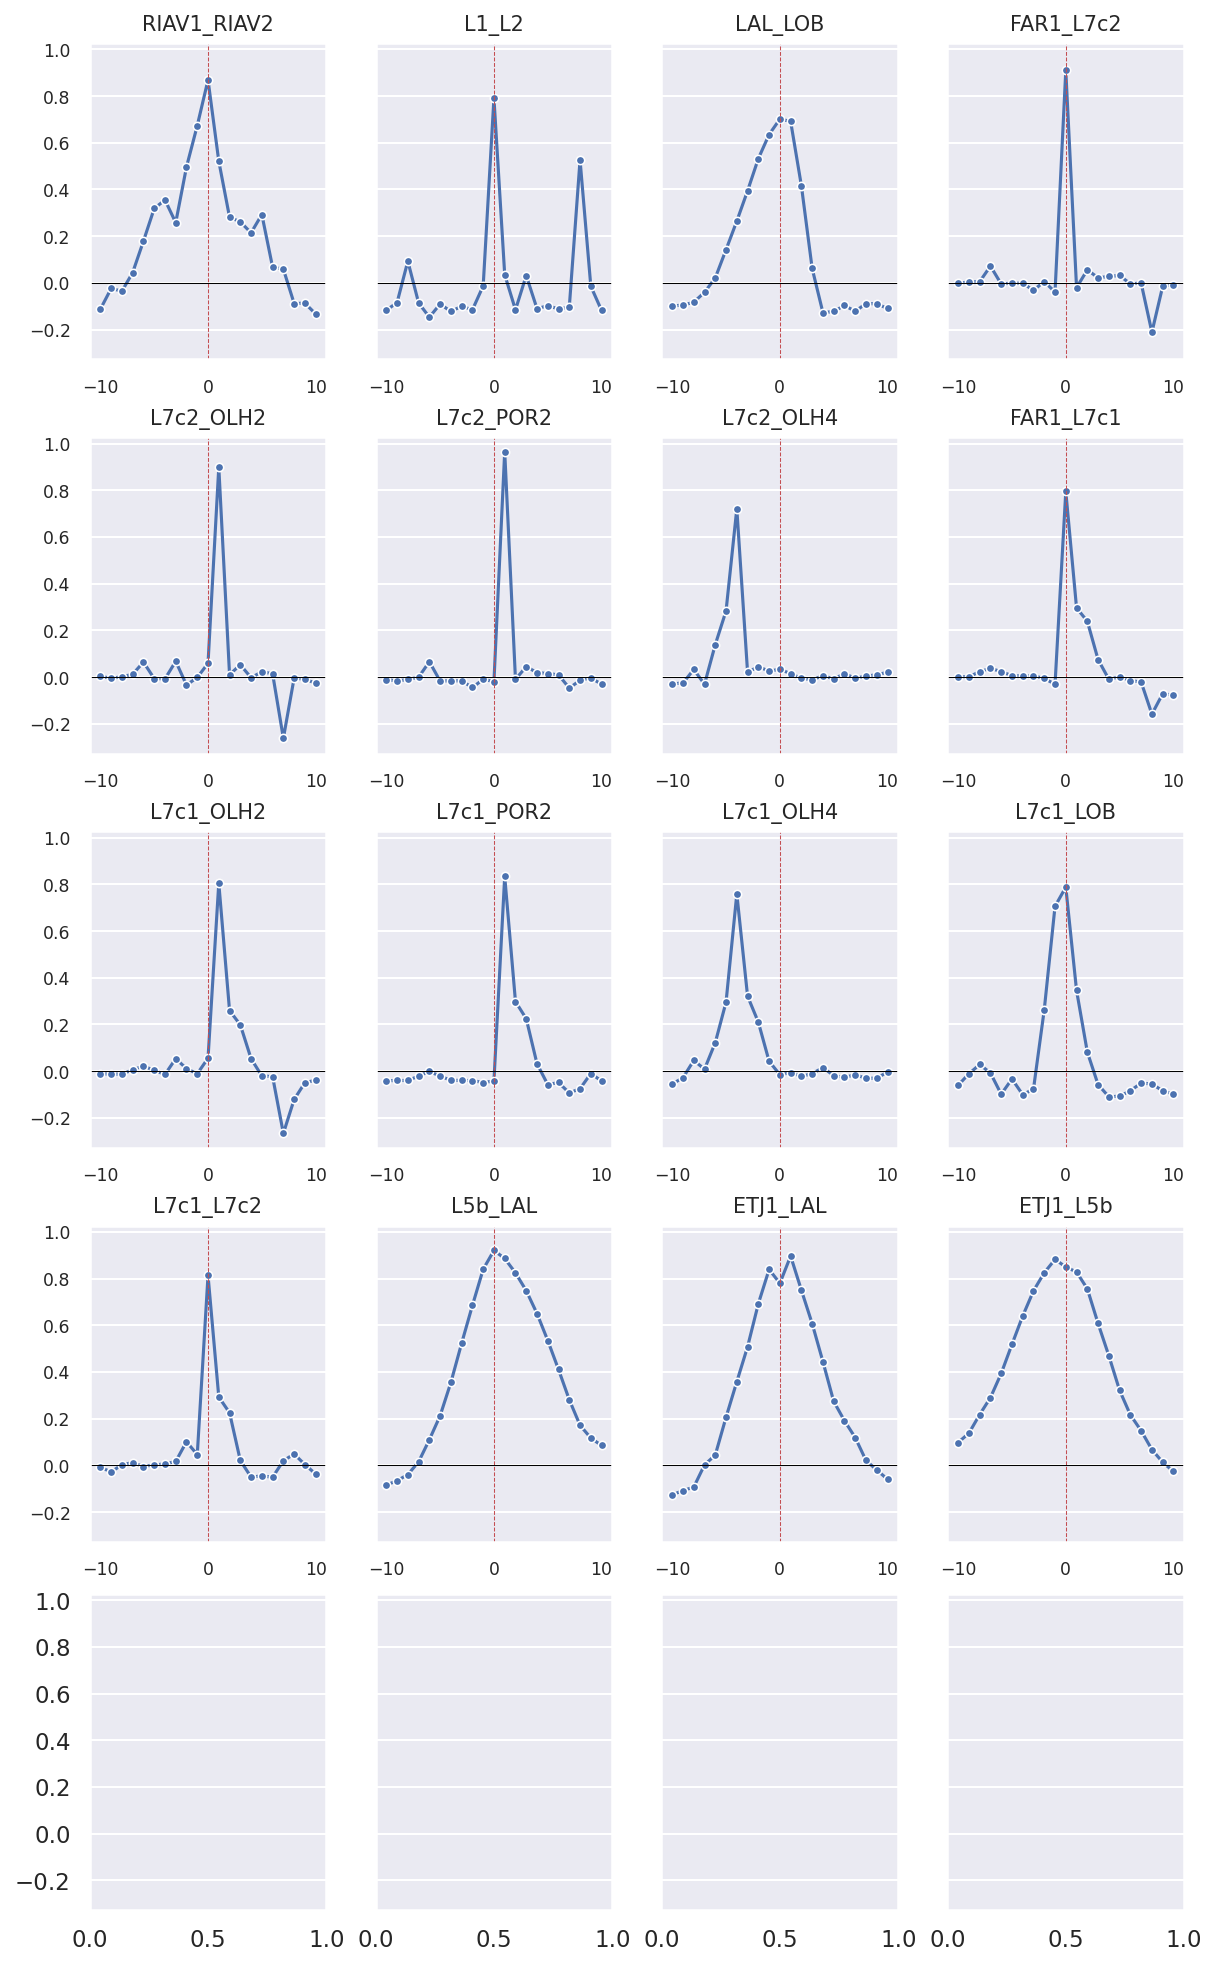

In [19]:
plot_corrs_single(all_areas, corr, lags, [], specie, target, type_corr='pearson', remove_default=True)

### Berbigão

corrs de berbigão todas a 0 pois não têm o limite minimo de 10 casos sem NaN para calcular correlação

In [52]:
specie = "Berbigão"
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()
corr = 0.01

#### DSP

In [53]:
target = "dsp_toxins"

##### With restrictions

In [54]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson')

In [55]:
plot_corrs_single(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson')

ValueError: Threshold too high, no correlations found

##### Without restrictions

In [56]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='pearson')

In [57]:
plot_corrs_single(all_areas, corr, lags, [], specie, target, type_corr='pearson')

ValueError: Threshold too high, no correlations found

#### ASP

In [58]:
target = "asp_toxins"

##### With restrictions

In [59]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson')

In [60]:
plot_corrs_single(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson', remove_default=True)

ValueError: Threshold too high, no correlations found

##### Without restrictions

In [61]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='pearson')

In [62]:
plot_corrs_single(all_areas, corr, lags, [], specie, target, type_corr='pearson', remove_default=True)

ValueError: Threshold too high, no correlations found

#### PSP

In [63]:
target = "psp_toxins"

##### With restrictions

In [64]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson')

In [65]:
plot_corrs_single(all_areas, corr, lags, area_groups, specie, target, type_corr='pearson', remove_default=True)

ValueError: Threshold too high, no correlations found

##### Without restrictions

In [66]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='pearson')

In [67]:
plot_corrs_single(all_areas, corr, lags, [], specie, target, type_corr='pearson', remove_default=True)

ValueError: Threshold too high, no correlations found

## DPCCA

In [39]:
k_range=[4,12,26,52]

### Mexilhão

In [40]:
specie = "Mexilhão"
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()
corr = 0.9

#### DSP

In [41]:
target = "dsp_toxins"

##### With restrictions

In [11]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

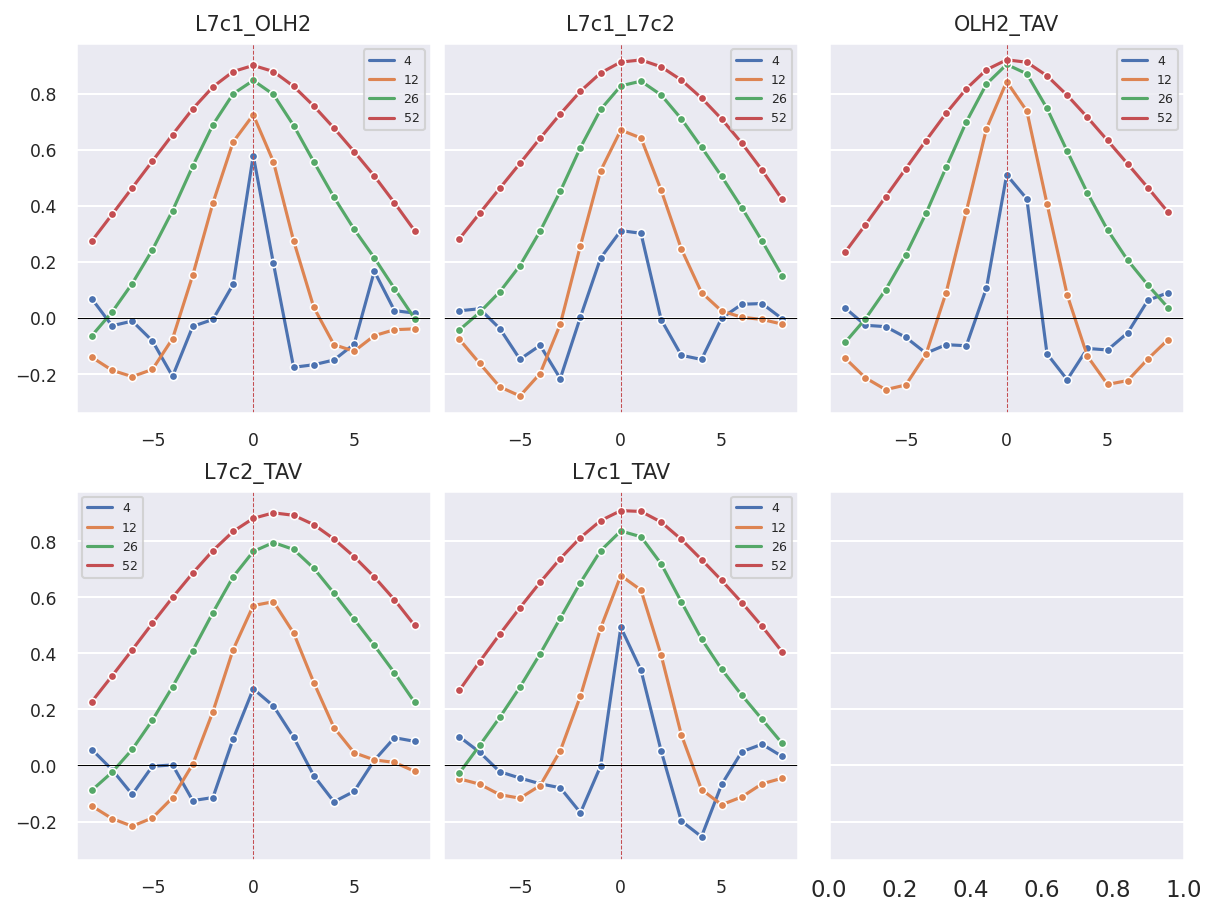

In [12]:
plot_dpcca_single(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

##### Without restrictions

In [77]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='dpcca', k_range=range(4,53,6))

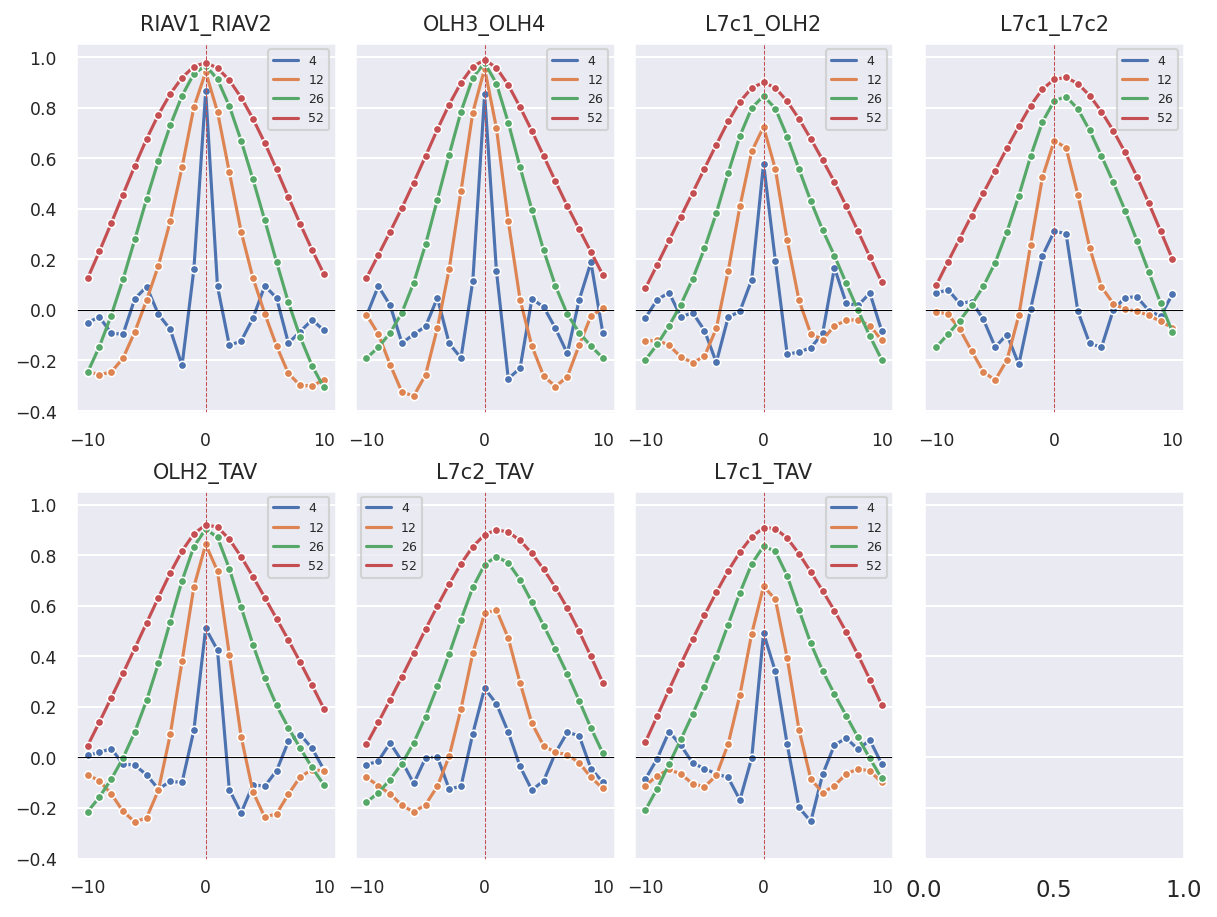

In [42]:
plot_dpcca_single(all_areas, corr, lags,  [], specie, target, type_corr='dpcca', k_range=[4,12,26,52],
                 subplots_per_line=4)

#### ASP

In [13]:
target = "asp_toxins"

##### With restrictions

In [14]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

In [15]:
plot_dpcca_single(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


LinAlgError: Singular matrix

##### Without restrictions

In [ ]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='dpcca', k_range=range(4,53,6))

In [ ]:
plot_dpcca_single(all_areas, corr, lags,  [], specie, target, type_corr='dpcca', k_range=[4,12,26,52])

#### PSP

In [19]:
target = "psp_toxins"
corr=0.95

##### With restrictions

In [20]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

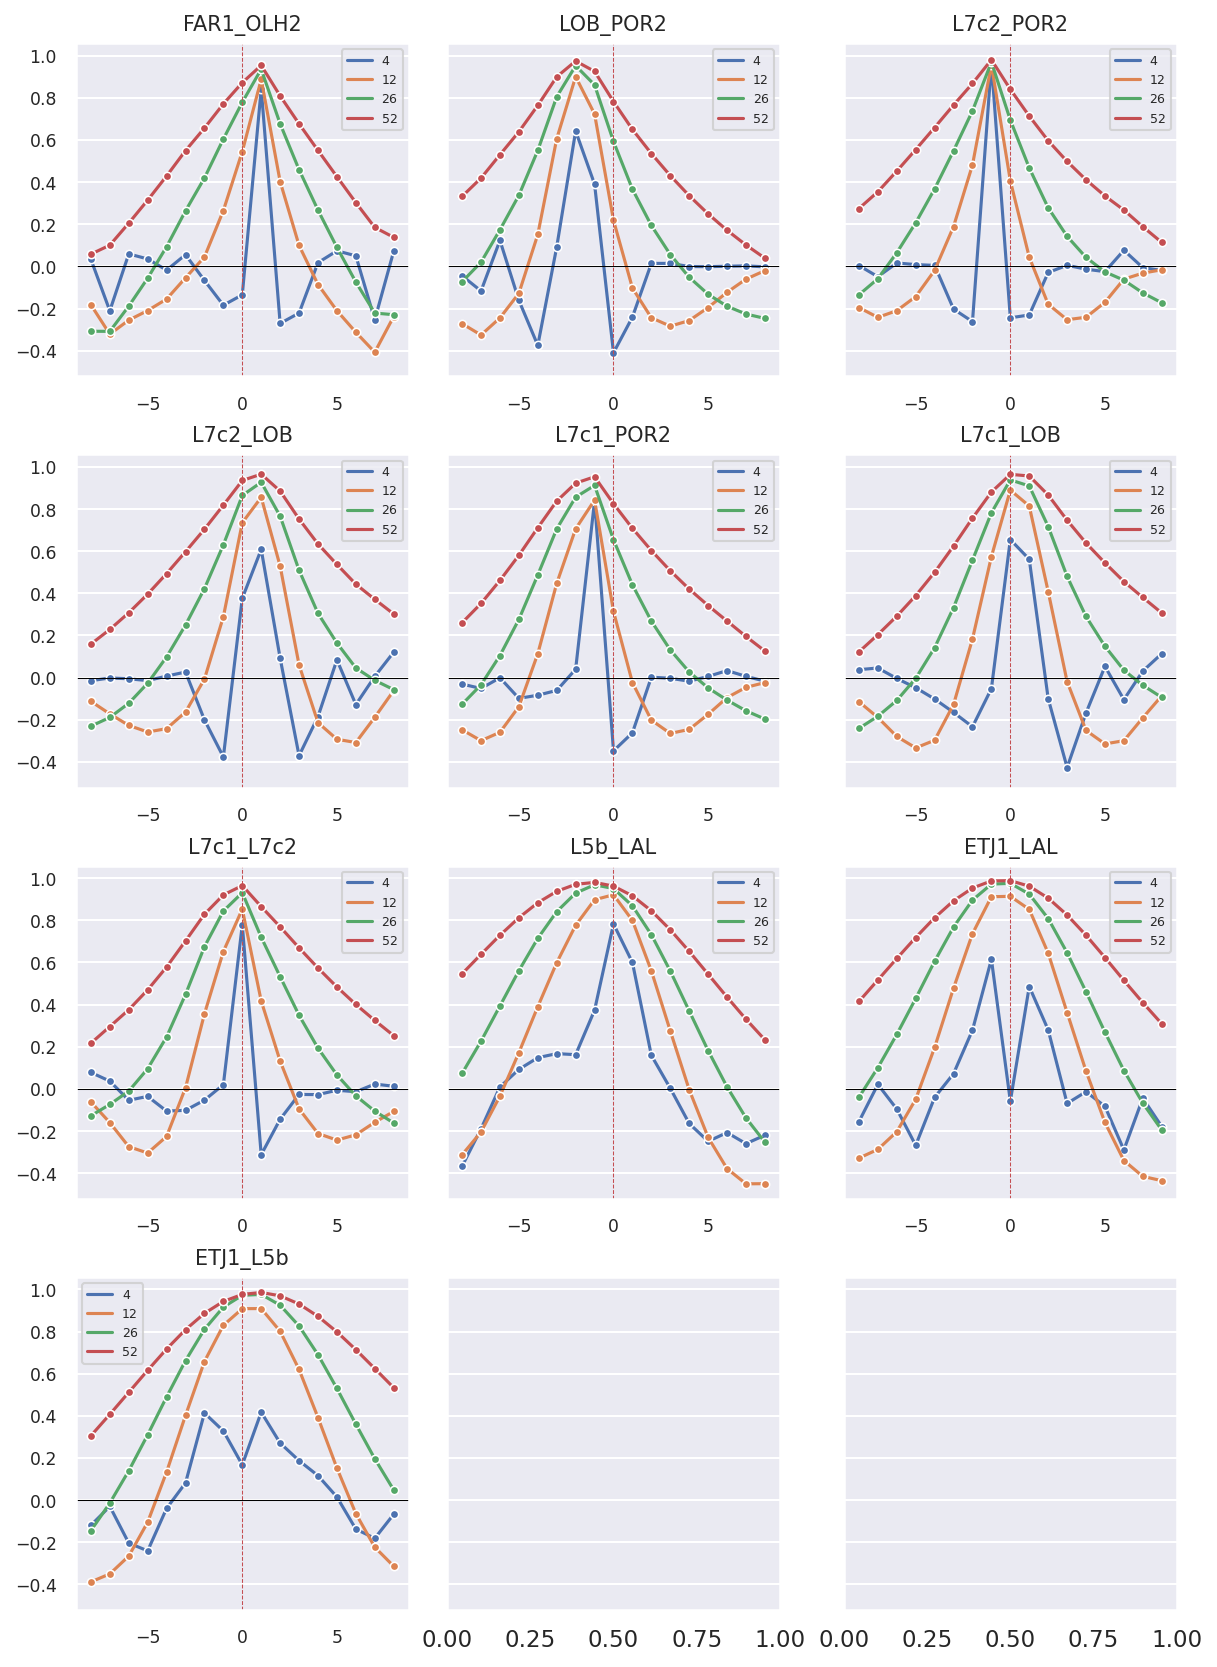

In [21]:
plot_dpcca_single(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

##### Without restrictions

In [194]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='dpcca', k_range=range(4,53,6))

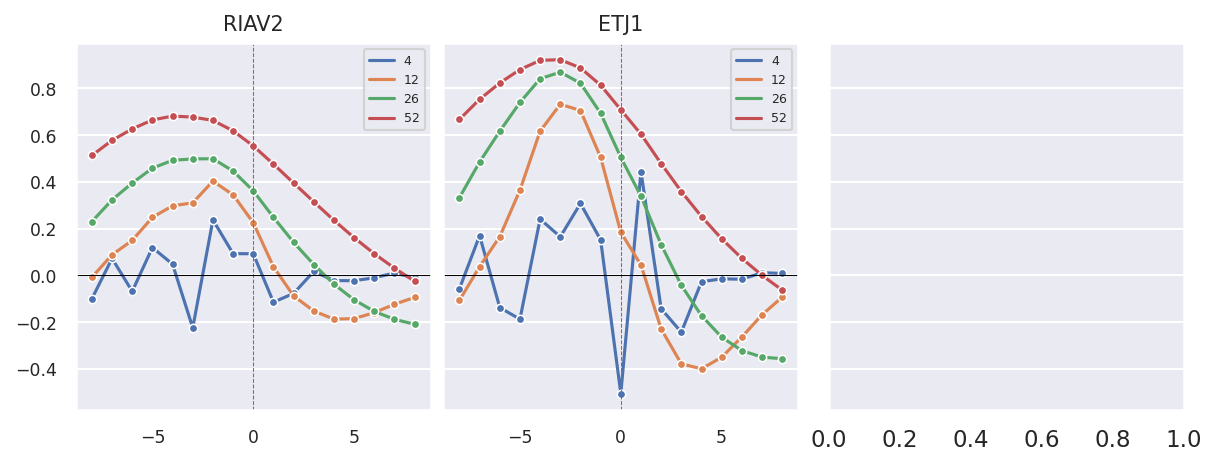

In [195]:
plot_dpcca_single(all_areas, corr, lags,  [], specie, target, type_corr='dpcca', k_range=[4,12,26,52])

### Berbigão

In [83]:
specie = "Berbigão"
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()
corr = 0.4

#### DSP

In [84]:
target = "dsp_toxins"

##### With restrictions

In [85]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

In [86]:
plot_dpcca_single(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

ValueError: Threshold too high, no correlations found

##### Without restrictions

In [87]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='dpcca', k_range=range(4,53,6))

In [88]:
plot_dpcca_single(all_areas, corr, lags,  [], specie, target, type_corr='dpcca', k_range=[4,12,26,52])

ValueError: Threshold too high, no correlations found

#### ASP

In [ ]:
target = "asp_toxins"

##### With restrictions

In [ ]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

In [ ]:
plot_dpcca_single(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

##### Without restrictions

In [ ]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='dpcca', k_range=range(4,53,6))

In [ ]:
plot_dpcca_single(all_areas, corr, lags,  [], specie, target, type_corr='dpcca', k_range=[4,12,26,52])

#### PSP

In [ ]:
target = "psp_toxins"

##### With restrictions

In [ ]:
#plot_corrs_all(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

In [ ]:
plot_dpcca_single(all_areas, corr, lags, area_groups, specie, target, type_corr='dpcca', k_range=k_range)

##### Without restrictions

In [ ]:
#plot_corrs_all(all_areas, corr, lags, [], specie, target, type_corr='dpcca', k_range=range(4,53,6))

In [ ]:
plot_dpcca_single(all_areas, corr, lags,  [], specie, target, type_corr='dpcca', k_range=[4,12,26,52])

# Phyto

In [82]:
lags = np.arange(-20, 21, 1)

In [91]:
def plot_corrs_single_phyto(all_areas, min_corr, lags, specie, target, suf="areacorr", type_corr="Pearson",
                      subplots_per_line=4, use_imputed=True, k_range=range(2,21,2), remove_default=False,
                           min_points_default=20):
    selected_areas = set()
    all_corrs = []
    for area in all_areas:
        try:
            if use_imputed:
                ts1 = get_ts_imputed(area, specie, target, suf, only_target=True)
                ts2 = get_ts_imputed(area, None, target, "phytocorr", only_target=True)
            else:
                ts1 = get_ts(biotoxins_ts, area, specie, target, "W", plot=False).interpolate(method="linear")
                ts2 = get_ts(phyto_ts, area, None, target, "W", plot=False).interpolate(method="linear")
        except FileNotFoundError:
            continue

        df = pd.merge(ts1, ts2, left_index=True, right_index=True)
        #display(df)
        col1, col2 = df.columns
        df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'areas': area})

        plot = False
        for lag in lags:
            temp = df.copy()
            temp[col1] = temp[col1].shift(lag)
            if type_corr.lower() == 'pearson':
                if remove_default:
                    default = temp[col1].mode().values[0]
                    temp = temp[~((temp[col1]-default<default*0.05) & (temp[col2]-default<default*0.05))]                        
                corr = temp[col1].corr(temp[col2], method='pearson', min_periods=min_points_default)                      
            else:
                raise ValueError("Invalid type_corr")
            df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
            if abs(corr) > min_corr:
                plot = True

        if plot:
            all_corrs.append(df_corrs)
        
    if len(all_corrs)==0:
        raise ValueError("Threshold too high, no correlations found")
    all_corrs = pd.concat(all_corrs)
    selected_areas = all_corrs["areas"].unique()
    #fig, axes = plt.subplots(len(selected_areas)//subplots_per_line + 1, subplots_per_line,  
    #                         figsize=(8,3*len(selected_areas)//subplots_per_line+1), constrained_layout=True, 
    #                         sharey=True)
    rows, columns = subplot_dim(len(selected_areas), subplots_per_line)
    fig, axes = plt.subplots(rows, columns, 
                             figsize=(10, 3*rows), constrained_layout=True, 
                             sharey=True, squeeze=False)
    axes = axes.ravel()
    for i, areas in enumerate(selected_areas):
        temp_df = all_corrs[all_corrs["areas"] == areas]
        sns.lineplot(data=temp_df, x="lags", y="corrs", marker='o', markersize=4, ax=axes[i])
        if type_corr.lower() in ['dpcca', 'dcca']:
            anchored_text = AnchoredText(f"k={k_dict[areas]}", loc='lower left', prop=dict(size=8))
            axes[i].add_artist(anchored_text)
        axes[i].set_title(f'{areas}', size="small")
        axes[i].tick_params(axis='both', labelsize="x-small")
        axes[i].set(xlabel=None, ylabel=None)
        #axes[i].set_ylim(-0.2,1)
        axes[i].axvline(0, linestyle="--", color="r", linewidth=0.5)
        axes[i].axhline(0, linestyle="-", color="black", linewidth=0.5)

    plt.show()
    return 0


def plot_dpcca_single_phyto(all_areas, min_corr, lags, specie, target, suf="areacorr", 
                      type_corr="dpcca", subplots_per_line=3, use_imputed=True, k_range=[12]):
    selected_areas = set()
    all_corrs = []
    for area in all_areas:
        try:
            if use_imputed:
                ts1 = get_ts_imputed(area, specie, target, suf, only_target=True)
                ts2 = get_ts_imputed(area, None, target, "phytocorr", only_target=True)
            else:
                ts1 = get_ts(biotoxins_ts, area1, specie, target, "W", plot=False).interpolate(method="linear")
                ts2 = get_ts(biotoxins_ts, area2, specie, target, "W", plot=False).interpolate(method="linear")
        except FileNotFoundError:
            continue

        df = pd.merge(ts1, ts2, left_index=True, right_index=True)
        col1, col2 = df.columns


        df_corrs = pd.DataFrame(columns=["lags", "corrs","areas",'n'])
        for n in k_range:
            df_corrs = df_corrs.append(pd.DataFrame({'lags':lags, 'corrs':np.nan, 'areas':area, 'n':str(n)}),
                                      ignore_index=True)
        #display(df_corrs)

        plot = False
        for n in k_range:
            for lag in lags:
                temp = df.copy()
                temp[col1] = temp[col1].shift(lag)

                if type_corr.lower() == 'dpcca':
                    z = 3
                elif type_corr.lower() == "dcca":
                    z = 2
                else:
                    raise ValueError("Invalid type_corr")
                corr = compute_dpcca_others(temp.dropna().values, n)[z][0][1]

                df_corrs.loc[(df_corrs['lags'] == lag) & (df_corrs['n']==str(n)), 'corrs'] = corr
                if abs(corr) > min_corr:
                    plot = True
        #display(df_corrs)    
        if plot:
            all_corrs.append(df_corrs)
        
    if len(all_corrs)==0:
        raise ValueError("Threshold too high, no correlations found")
    all_corrs = pd.concat(all_corrs)
    selected_areas = all_corrs["areas"].unique()
    fig, axes = plt.subplots(len(selected_areas)//subplots_per_line + 1, subplots_per_line,  
                             figsize=(8,3*len(selected_areas)//subplots_per_line+1), constrained_layout=True, 
                             sharey=True)
    axes = axes.ravel()
    for i, areas in enumerate(selected_areas):
        temp_df = all_corrs[all_corrs["areas"] == areas]
        sns.lineplot(data=temp_df, x="lags", y="corrs", hue="n", marker='o', markersize=4, ax=axes[i])
        #if type_corr.lower() in ['dpcca', 'dcca']:
            #anchored_text = AnchoredText(f"k={k_dict[areas]}", loc='lower left', prop=dict(size=8))
            #axes[i].add_artist(anchored_text)
        axes[i].set_title(f'{areas}', size="small")
        axes[i].tick_params(axis='both', labelsize="x-small")
        axes[i].set(xlabel=None, ylabel=None)
        #axes[i].set_ylim(-0.2,1)
        axes[i].axvline(0, linestyle="--", color="r", linewidth=0.5)
        axes[i].axhline(0, linestyle="-", color="black", linewidth=0.5)
        axes[i].legend(prop={'size': 6})

    plt.show()

## Pearson

### Mexilhão

In [89]:
specie = "Mexilhão"
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()

#### DSP

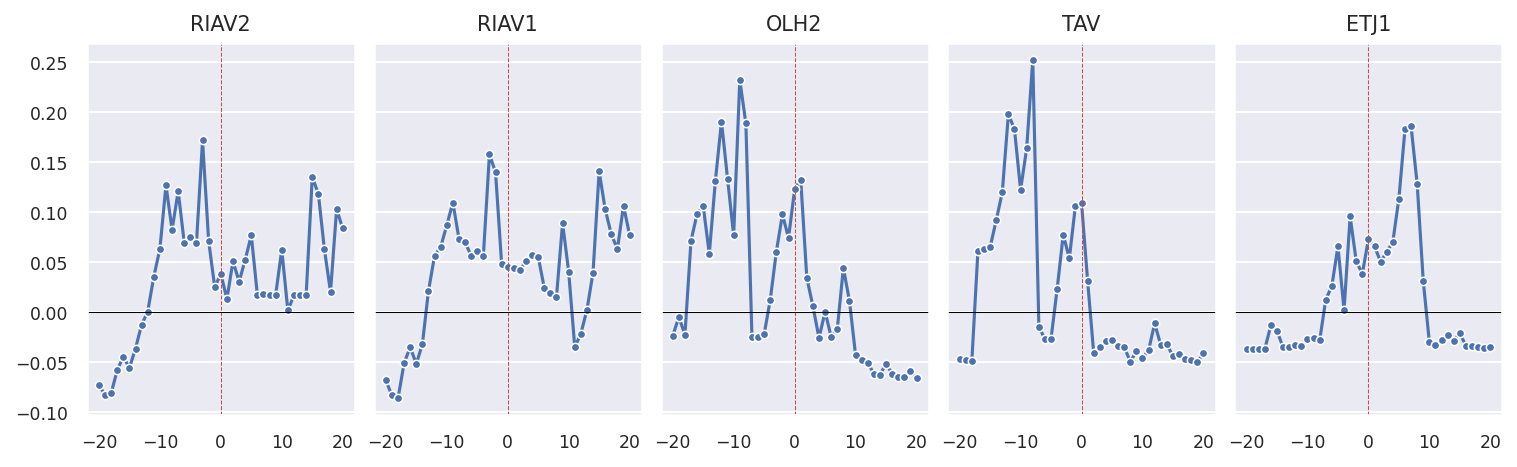

0

In [92]:
corr = 0.15
target = "dsp_toxins"
plot_corrs_single_phyto(all_areas, corr, lags, specie, target, type_corr='pearson', subplots_per_line=5)

#### ASP

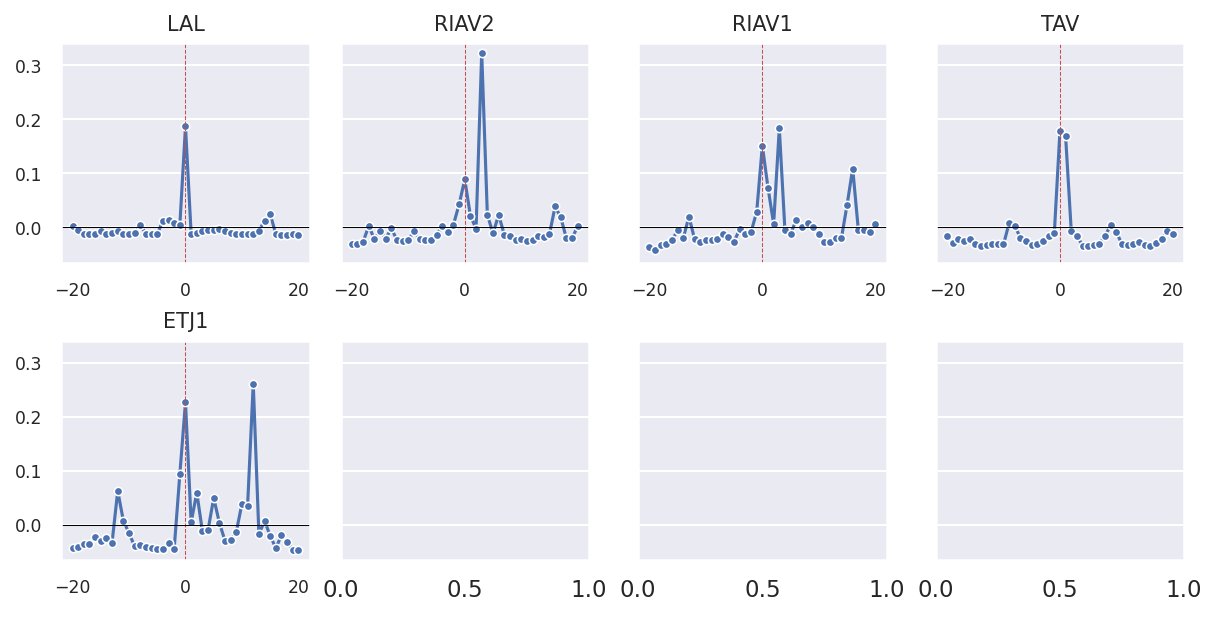

0

In [82]:
corr = 0.15
target = "asp_toxins"
plot_corrs_single_phyto(all_areas, corr, lags, specie, target, type_corr='pearson', sub)

#### PSP

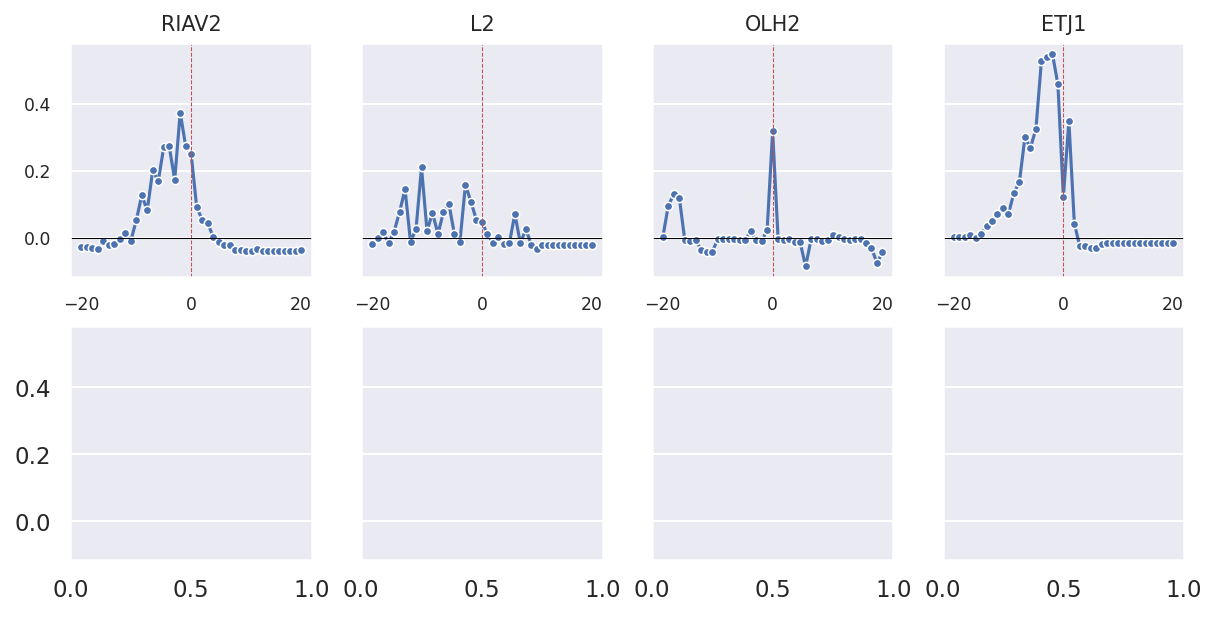

0

In [83]:
corr = 0.15
target = "psp_toxins"
plot_corrs_single_phyto(all_areas, corr, lags, specie, target, type_corr='pearson')

## DPCCA

In [84]:
k_range=[4,12,26,52]

### Mexilhão

In [86]:
specie = "Mexilhão"
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()

#### DSP

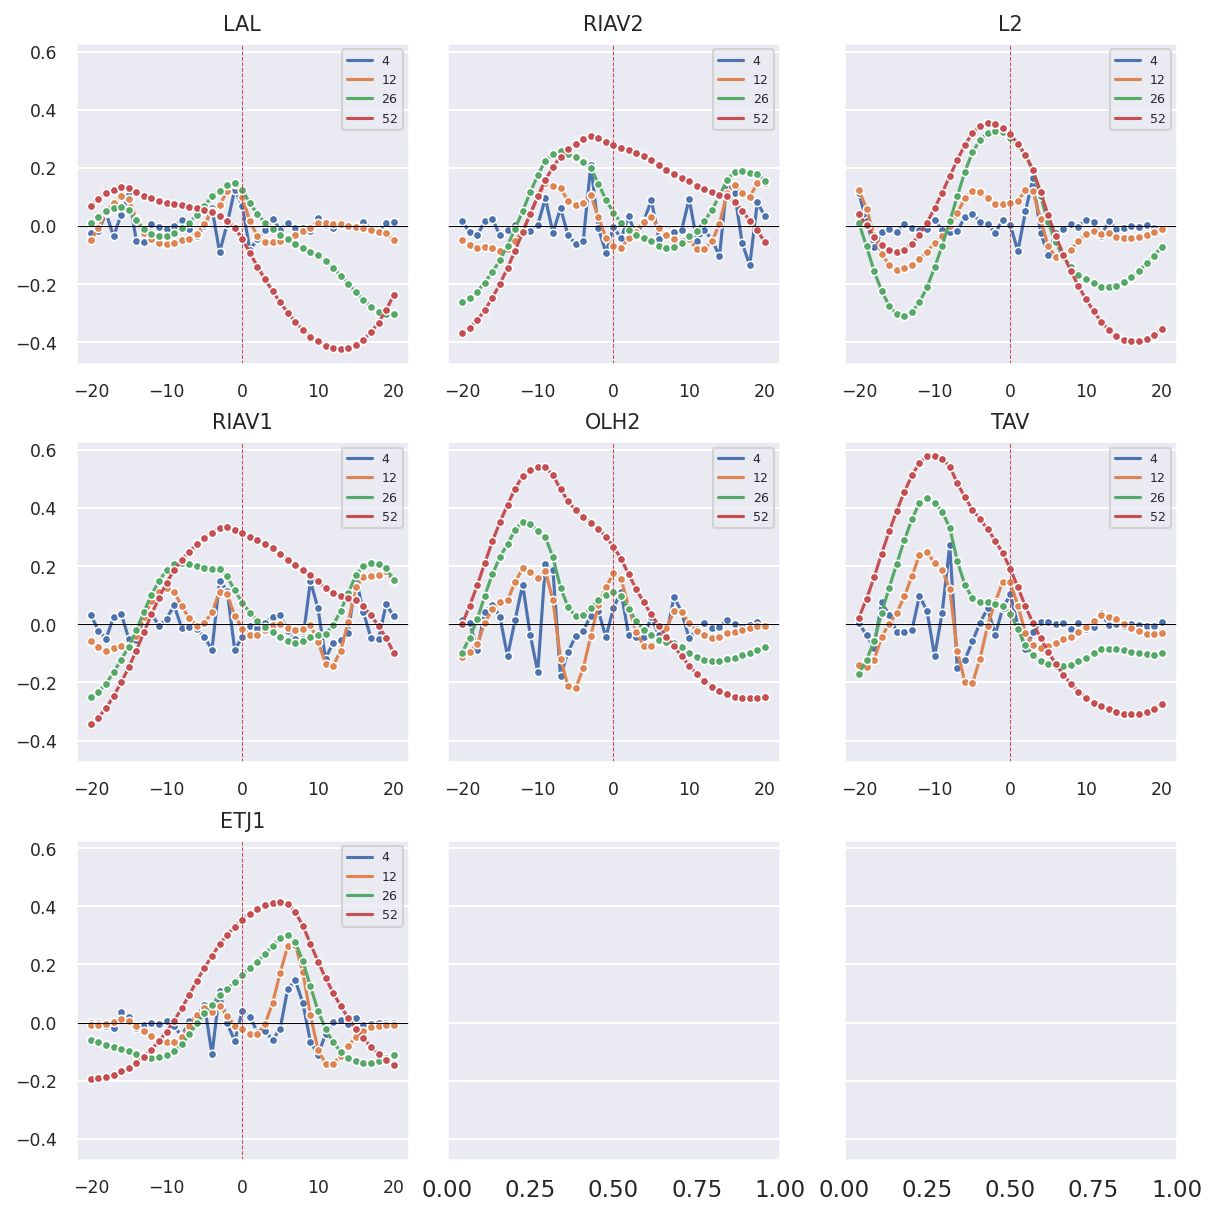

In [87]:
target = "dsp_toxins"
corr = 0.3
plot_dpcca_single_phyto(all_areas, corr, lags, specie, target, type_corr='dpcca', k_range=k_range)

#### ASP

In [88]:
target = "asp_toxins"
corr = 0.3
plot_dpcca_single_phyto(all_areas, corr, lags, specie, target, type_corr='dpcca', k_range=k_range)

/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


LinAlgError: Singular matrix

#### PSP

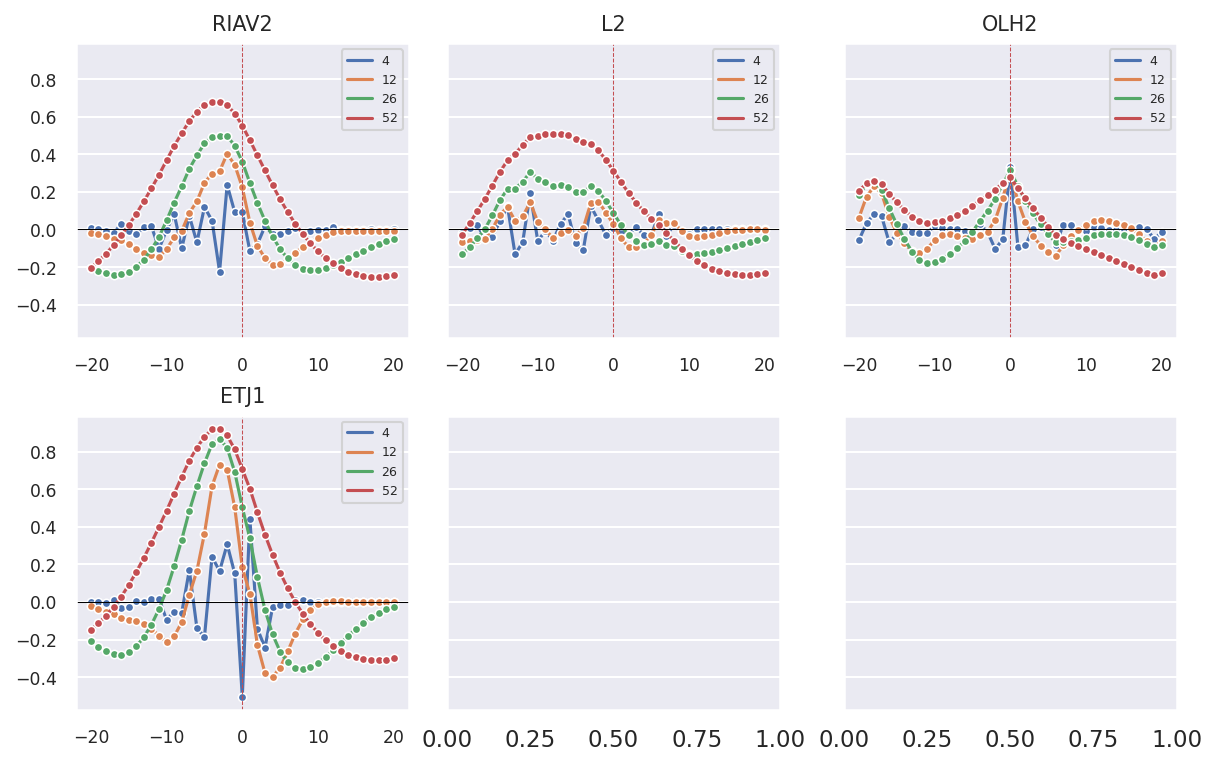

In [89]:
target = "psp_toxins"
corr = 0.3
plot_dpcca_single_phyto(all_areas, corr, lags, specie, target, type_corr='dpcca', k_range=k_range)